### Importing the main libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()

import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.set_default_dtype(torch.float32)

%matplotlib inline

### Use GPU if available

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


### Bernstein Polynomials

In [3]:
from utils.bernstein_torch import bernstein_coeff_order10_new

# Generating P matrix
t_fin = 15.0
num = 100
tot_time = torch.linspace(0, t_fin, num)
tot_time_copy = tot_time.reshape(num, 1)
P, Pdot, Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)

### Dataset Loader

In [4]:
import scipy.io as sio

# Custom Dataset Loader 
class TrajDataset(Dataset):
    """Expert Trajectory Dataset."""
    def __init__(self, obs, traj):
        
        # Inputs
        self.inp = obs
        
        # Outputs
        self.out = traj
        
    def __len__(self):
        return len(self.inp)
    
    def __getitem__(self, idx):
        
        # Inputs
        inp = self.inp[idx]
        
        # Outputs
        out = self.out[idx]
                 
        return torch.tensor(inp).float(), torch.tensor(out).float()

# Load the dataset
obs = sio.loadmat("./dataset/four_lane_dataset.mat")["observations"]
traj = sio.loadmat("./dataset/four_lane_dataset.mat")["trajectories"]

# Using PyTorch Dataloader
train_dataset = TrajDataset(obs, traj)
train_loader = DataLoader(train_dataset, batch_size=8000, shuffle=True, num_workers=0, drop_last=True)

torch.Size([8000, 55]) torch.Size([8000, 200])


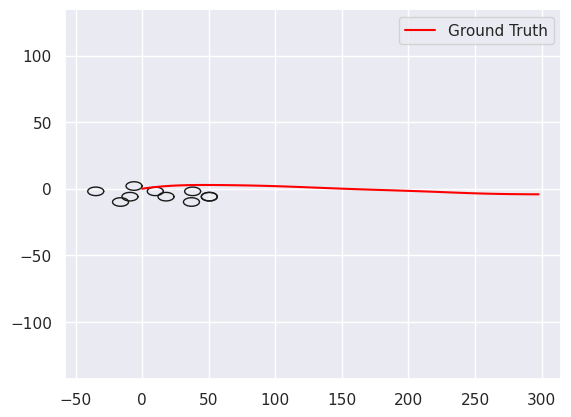

In [5]:
# Sanity Check

for batch_num, (datas) in enumerate(train_loader):
    inp, out = datas
    
    print(inp.shape, out.shape)
        
    num = 2
    
    # Sanity Check
    x_obs = inp[num].flatten()[5::5]
    y_obs = inp[num].flatten()[6::5]
     
    th = np.linspace(0, 2 * np.pi, 100)
    plt.figure(1)
    
    a_obs, b_obs = 6.0, 3.2
    
    for i in range(0, 10):
        x_ell = x_obs[i] + a_obs * np.cos(th)
        y_ell = y_obs[i] + b_obs * np.sin(th)
        plt.plot(x_ell, y_ell, '-k', linewidth=1.0)

    plt.axis('equal')
        
    x = out[num].flatten()[0:100]
    y = out[num].flatten()[100:]
        
    plt.plot(x.numpy(), y.numpy(), label="Ground Truth", color="red")
    plt.legend()
    plt.show()
    
    break

### CVAE embedded with a Differentiable Optimization Layer

In [7]:
from models.cvae_qp_stack import Encoder, Decoder, Beta_cVAE

# Bernstein Polynomial
num_batch = train_loader.batch_size
P = P.to(device)
Pdot = Pdot.to(device)
Pddot = Pddot.to(device)
P_diag = torch.block_diag(P, P) 

# Beta-cVAE Inputs
enc_inp_dim = 55
enc_out_dim = 200
dec_inp_dim = enc_inp_dim
dec_out_dim = 30 # first 8 behavioral params and 11 lamda x / y's each 
hidden_dim = 1024 * 2
z_dim = 2

# Normalization Constant
inp_mean, inp_std = -0.1904783993959427, 37.758968353271484

# CVAE Encoder-Decoder
encoder = Encoder(enc_inp_dim, enc_out_dim, hidden_dim, z_dim)
decoder = Decoder(dec_inp_dim, dec_out_dim, hidden_dim, z_dim)
model = Beta_cVAE(P, Pdot, Pddot, encoder, decoder, num_batch, inp_mean, inp_std).to(device)

### Training Loop

In [8]:
epochs = 180
step, beta = 0, 3.5
optimizer = optim.AdamW(model.parameters(), lr = 2e-4, weight_decay=6e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1)

avg_train_loss, avg_rcl_loss, avg_kl_loss, avg_aug_loss = [], [], [], []
for epoch in range(epochs):
    
    # Train Loop
    losses_train, kl_losses, rcl_losses, aug_losses = [], [], [], []
    model.train()
    for inp, out in train_loader:
        
        inp = inp.to(device)
        traj_gt = out.to(device)
        
        # Ego vehicle states
        initial_state_ego = inp[:, 2:6]
        initial_state_ego[:, 2:4] = initial_state_ego[:, 0:2]
        initial_state_ego[:, 0:2] = 0
               
        # Prediction & Encoder outputs
        traj_sol, res_norm_batch, mu, std= model(inp, traj_gt, initial_state_ego, P_diag)

        # Loss Function
        aug_loss, KL_loss, RCL_loss, loss = model.cvae_loss(traj_sol, traj_gt, res_norm_batch, mu, std, beta, step)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses_train.append(loss.detach().cpu().numpy()) 
        rcl_losses.append(RCL_loss.detach().cpu().numpy())
        kl_losses.append(KL_loss.detach().cpu().numpy())
        aug_losses.append(aug_loss.detach().cpu().numpy())

    if epoch % 4 == 0:    
        print(f"Epoch: {epoch + 1}, Train Loss: {np.average(losses_train):.3f}, RCL: {np.average(rcl_losses):.3f}, KL: {np.average(kl_losses):.3f}, Aug: {np.average(aug_losses):.3f}")

    step += 0.25 # 0.25
    scheduler.step()
    avg_train_loss.append(np.average(losses_train)), avg_rcl_loss.append(np.average(rcl_losses)), \
    avg_kl_loss.append(np.average(kl_losses)), avg_aug_loss.append(np.average(aug_losses))

Epoch: 1, Train Loss: 94.330, RCL: 82.351, KL: 11.217, Aug: 11.979
Epoch: 5, Train Loss: 77.447, RCL: 67.971, KL: 15.853, Aug: 9.421
Epoch: 9, Train Loss: 36.301, RCL: 28.268, KL: 17.387, Aug: 7.911
Epoch: 13, Train Loss: 33.551, RCL: 25.639, KL: 17.050, Aug: 7.734
Epoch: 17, Train Loss: 32.568, RCL: 24.809, KL: 18.169, Aug: 7.505
Epoch: 21, Train Loss: 39.545, RCL: 31.212, KL: 18.795, Aug: 8.004
Epoch: 25, Train Loss: 30.337, RCL: 23.192, KL: 18.152, Aug: 6.764
Epoch: 29, Train Loss: 30.450, RCL: 23.373, KL: 16.888, Aug: 6.663
Epoch: 33, Train Loss: 30.716, RCL: 23.441, KL: 17.194, Aug: 6.794
Epoch: 37, Train Loss: 28.064, RCL: 20.971, KL: 16.916, Aug: 6.561
Epoch: 41, Train Loss: 28.318, RCL: 21.123, KL: 16.661, Aug: 6.612
Epoch: 45, Train Loss: 27.870, RCL: 20.633, KL: 16.199, Aug: 6.613
Epoch: 49, Train Loss: 27.706, RCL: 20.433, KL: 15.722, Aug: 6.612
Epoch: 53, Train Loss: 27.491, RCL: 20.173, KL: 15.232, Aug: 6.625
Epoch: 57, Train Loss: 27.790, RCL: 20.509, KL: 14.929, Aug: 6.5

KeyboardInterrupt: 

### Saving the Weights

In [ ]:
torch.save(model.state_dict(), './weights/new_model.pth')